# Scattering Parameters Parameterization
#### Predicting input parameters using simulation data

### Group 49

- **Rajath Rajendra Pai**
  - Email: [rajathra@student.chalmers.se](mailto:rajathra@student.chalmers.se)

- **Konrad Komischke**
  - Email: [konradk@student.chalmers.se](mailto:konradk@student.chalmers.se)

In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from scipy.spatial import distance
import matplotlib.pyplot as plt


## Data Preprocessing

In [2]:
# Open the MATLAB .mat file in read mode
mat_file = h5py.File('data.mat', 'r')

# Access the "data_base" structure
data_base = mat_file['data_base']

# Extract the "class_label" column
class_labels_data = data_base['class_label']

# Initialize a list to store the extracted class labels
class_labels = []

# Iterate through the "class_label" data structure and convert ASCII values to strings
for i in range(len(class_labels_data)):
    # Access the HDF5 object reference
    reference = class_labels_data[i][0]
    
    # Convert ASCII values to a string
    class_label = ''.join(chr(c[0]) for c in mat_file[reference][:])
    
    class_labels.append(class_label)

# Extract the "meta_data" column
meta_data = data_base['meta_data']

# Initialize a list to store the extracted meta_data
meta_data_values = []

# Iterate through the "meta_data" data structure and convert arrays to lists
for i in range(len(meta_data)):
    # Access the HDF5 object reference
    reference = meta_data[i][0]
    
    # Convert the HDF5 dataset to a list
    meta_data_list = mat_file[reference][:].tolist()
    
    meta_data_values.append(meta_data_list)

# Extract the "raw" column
raw_data = data_base['raw']

# Initialize a list to store the extracted raw data
raw_values = []

# Iterate through the "raw" data structure and extract the complex arrays
for i in range(len(raw_data)):
    # Access the HDF5 object reference
    reference = raw_data[i][0]
    
    # Extract the complex array
    raw_array = mat_file[reference][()]
    
    # Append the complex array to the list
    raw_values.append(raw_array)

# Now, 'class_labels' is a list containing the actual string labels like 'Healthy' or 'Bleeding'
# 'meta_data_values' is a list containing lists of numbers like [0.8569, 0.933, 0.7916, 4, 0, 0, 0, 0]
# 'raw_values' is a list containing 1000x136 complex double arrays

# Close the HDF5 file
mat_file.close()

# Print the extracted data
print("Class Labels:")
print(class_labels)

print("\nMeta Data:")
for item in meta_data_values:
    print(item)

print("\nRaw Data for the First Element:")
print(raw_values[0])  # This will print the 1000x136 complex array


Class Labels:
['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healt

converting complex numbers to their absolute values

In [3]:
# Initialize a list to store the absolute values
absolute_values = []

# Iterate through the complex arrays and calculate the absolute values
for complex_array in raw_values:
    # Convert the structured array to a complex number
    complex_number = complex_array['real'] + 1j * complex_array['imag']
    
    # Calculate the absolute value of the complex number
    absolute_value = abs(complex_number)
    
    # Append the absolute value to the list
    absolute_values.append(absolute_value)

# Now, 'absolute_values' contains the absolute values of the complex arrays

# Print the absolute values for a specific element (e.g., the first element)
print("Absolute Values for the First Element:")
print(absolute_values[0])  # This will print the absolute values

Absolute Values for the First Element:
[[0.734685   1.19166477 1.24511849 ... 0.483988   0.46185855 0.43994064]
 [0.129947   0.059536   0.03243386 ... 0.02240725 0.02267934 0.02282618]
 [0.13417    0.06146746 0.03348113 ... 0.01614781 0.01635431 0.01644072]
 ...
 [0.0391404  1.04829822 1.13299126 ... 0.73098786 0.73640361 0.74855492]
 [0.0263382  0.01208248 0.00660707 ... 0.01897918 0.01831952 0.01759135]
 [3.06859    1.99427591 1.69737367 ... 0.3820441  0.39150157 0.40464487]]


Find out which antenas(which columns in the dataset) to use

In [4]:
import itertools as it


N_antennas = 16

# Edit here to set antennas
antenna_numbers = [2, 6, 7, 11, 14]

indices_to_keep = []

print('Reflection coefficient indices:')
for i in antenna_numbers:
    index = 1 + sum(range(N_antennas-i+2, N_antennas+1))
    indices_to_keep.append(index)
    print(f'S_{{{i},{i}}}: {index}')

print()
print('Transmission coefficient indices:')
for i, j in it.product(antenna_numbers, antenna_numbers):
    if i >= j:
        continue
    index = 1 + sum(range(N_antennas-i+2, N_antennas+1)) + j - i
    indices_to_keep.append(index)
    print(f'S_{{{i},{j}}}: {index}')



print('\n\n The index we will be using are: ')
print(indices_to_keep)

Reflection coefficient indices:
S_{2,2}: 17
S_{6,6}: 71
S_{7,7}: 82
S_{11,11}: 116
S_{14,14}: 131

Transmission coefficient indices:
S_{2,6}: 21
S_{2,7}: 22
S_{2,11}: 26
S_{2,14}: 29
S_{6,7}: 72
S_{6,11}: 76
S_{6,14}: 79
S_{7,11}: 86
S_{7,14}: 89
S_{11,14}: 119


 The index we will be using are: 
[17, 71, 82, 116, 131, 21, 22, 26, 29, 72, 76, 79, 86, 89, 119]


## Data Cleaning

In [5]:
# create a dataframe with raw_values, class_labels, meta_data_values
df_original = pd.DataFrame({'features': absolute_values, 'class_labels': class_labels, 'labels': meta_data_values})
df = df_original.copy()
# create a new column with the absolute values

Removing the rows that have class_labels as bleeding.

In [6]:
df = df[df['class_labels'] != 'Bleeding']

Removing zeros from the meta_data_values

In [7]:
# each meta_data_values is a list of 8 values, we only need the first 4 values
df['labels'] = df['labels'].apply(lambda x: x[:4])

Removing all columns other than [17, 71, 82, 116, 131, 21, 22, 26, 29, 72, 76, 79, 86, 89, 119]

In [8]:
# transpose each list in the list of features to get a list of 1000 row and 136 columns
df['features'] = df['features'].apply(lambda x: x.T) 

In [9]:
# Iterate through the rows and keep only the specified columns in "features"
for i in range(len(df)):
    df.at[i, 'features'] = df.at[i, 'features'][:, indices_to_keep]

## Training

In [33]:


def calculate_average_euclidean_distance(X_test, y_test, models):
    # Initialize a list to store the Euclidean distances
    model = models
    distances = []

    y_true = y_test.squeeze()

    y_pred = model.predict(X_test)

    # Iterate through the predicted and true labels
    for i in range(len(y_true)):
        predicted_label = y_pred[i]
        true_label = y_true[i]  # Access the individual element within y_true

        print(f'Predicted label: {predicted_label}, True label: {true_label}')

        # Calculate the Euclidean distance between the predicted and true labels
        euclidean_dist = distance.euclidean(predicted_label, true_label)

        # Append the distance to the list
        distances.append(euclidean_dist)

    # Calculate the average Euclidean distance
    average_distance = sum(distances) / len(distances)
    
    print(f'Average Euclidean Distance: {average_distance:.4f}')


#### Basic model

In [11]:
# Split the data into training and testing sets (adjust the test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(df['features'], df['labels'], test_size=0.2, random_state=42)

# Convert X_train and y_train to NumPy arrays
X_train = np.array(X_train.tolist())
y_train = np.array(y_train.tolist())

# Convert X_test and y_test to NumPy arrays
X_test = np.array(X_test.tolist())
y_test = np.array(y_test.tolist())

# Define a neural network model
model = models.Sequential([
    layers.Input(shape=(1000, 15)),  # Input shape matches the shape of your features
    layers.Flatten(),  # Flatten the input matrix
    layers.Dense(64, activation='relu'),  # Add a dense layer with ReLU activation
    layers.Dense(4)  # Output layer with 4 units (to match the label dimension)
])

# Compile the model with an appropriate loss function (e.g., mean squared error for regression)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, mse = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


Epoch 1/10
25/25 [==============================] - 1s 17ms/step - loss: 0.3311 - mse: 0.3311 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 2/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 3/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 4/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 7/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 8/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0067 - m

In [34]:
calculate_average_euclidean_distance(X_test, y_test,model)

1/7 [===>..........................] - ETA: 0s7/7 [==============================] - 0s 5ms/step
Predicted label: [0.8187202  0.93370706 0.83436733 0.8651705 ], True label: [0.810229 0.938008 0.844946 1.      ]
Predicted label: [0.8712508  0.93930894 0.8223259  3.1208878 ], True label: [0.844594 0.934918 0.81061  3.      ]
Predicted label: [0.88971525 0.86096454 0.8264489  3.039142  ], True label: [0.857101 0.840641 0.815754 3.      ]
Predicted label: [0.84622496 0.938815   0.8118453  0.07613254], True label: [0.814325 0.949077 0.77585  0.      ]
Predicted label: [0.8245283  0.8905071  0.83500767 3.0762784 ], True label: [0.818404 0.906603 0.83802  3.      ]
Predicted label: [0.7909891  0.85288036 0.8303934  0.10164294], True label: [0.768411 0.88819  0.866375 0.      ]
Predicted label: [0.82854646 0.891492   0.7644768  3.0672262 ], True label: [0.818446 0.901404 0.776607 3.      ]
Predicted label: [0.871105  0.8876381 0.8885079 3.0662954], True label: [0.8375   0.876077 0.868458 3.   

#### neural network model with an LSTM layer

In [13]:


# Split the data into training and testing sets (adjust the test_size as needed)
lstm_X_train, lstm_X_test, lstm_y_train, lstm_y_test = train_test_split(df['features'], df['labels'], test_size=0.2, random_state=42)

# Convert lstm_X_train and lstm_y_train to NumPy arrays
lstm_X_train = np.array(lstm_X_train.tolist())
lstm_y_train = np.array(lstm_y_train.tolist())

# Convert lstm_X_test and lstm_y_test to NumPy arrays
lstm_X_test = np.array(lstm_X_test.tolist())
lstm_y_test = np.array(lstm_y_test.tolist())

# Define a neural network model with an LSTM layer
lstm_model = models.Sequential([
    layers.Input(shape=(1000, 15)),  # Input shape matches the shape of your features
    layers.LSTM(64, activation='relu', return_sequences=True),  # LSTM layer with return_sequences=True to output a sequence
    layers.Flatten(),  # Flatten the LSTM output
    layers.Dense(64, activation='relu'),  # Add a dense layer with ReLU activation
    layers.Dense(4)  # Output layer with 4 units (to match the label dimension)
])

# Compile the lstm_model with an appropriate loss function (e.g., mean squared error for regression)
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the lstm_model
lstm_history = lstm_model.fit(lstm_X_train, lstm_y_train, epochs=10, batch_size=32, validation_data=(lstm_X_test, lstm_y_test))

# Evaluate the lstm_model on the test set
lstm_loss, lstm_mse = lstm_model.evaluate(lstm_X_test, lstm_y_test)
print(f'Test Loss: {lstm_loss:.4f}')
print(f'Mean Squared Error: {lstm_mse:.4f}')

Epoch 1/10
25/25 [==============================] - 9s 306ms/step - loss: 0.1941 - mse: 0.1941 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 2/10
25/25 [==============================] - 7s 292ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 3/10
25/25 [==============================] - 7s 293ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 4/10
25/25 [==============================] - 8s 307ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 5/10
25/25 [==============================] - 7s 297ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 6/10
25/25 [==============================] - 7s 294ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/10
25/25 [==============================] - 7s 294ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 8/10
25/25 [==============================] - 7s 294ms/step - loss: 0.

In [35]:
calculate_average_euclidean_distance(lstm_X_test, lstm_y_test,lstm_model)

7/7 [==============================] - 2s 180ms/step
Predicted label: [0.81941575 0.92736995 0.83608097 0.9759683 ], True label: [0.810229 0.938008 0.844946 1.      ]
Predicted label: [0.849773   0.92084736 0.79067713 3.0344667 ], True label: [0.844594 0.934918 0.81061  3.      ]
Predicted label: [0.8590061  0.83249533 0.8096183  3.0532749 ], True label: [0.857101 0.840641 0.815754 3.      ]
Predicted label: [ 0.8101263   0.92877054  0.7651717  -0.0275164 ], True label: [0.814325 0.949077 0.77585  0.      ]
Predicted label: [0.8118201 0.8888371 0.8090114 3.0488358], True label: [0.818404 0.906603 0.83802  3.      ]
Predicted label: [0.76362807 0.8717431  0.8657431  0.06242695], True label: [0.768411 0.88819  0.866375 0.      ]
Predicted label: [0.82160074 0.8960713  0.7715572  3.0285988 ], True label: [0.818446 0.901404 0.776607 3.      ]
Predicted label: [0.8683616  0.88984096 0.8701904  3.1078358 ], True label: [0.8375   0.876077 0.868458 3.      ]
Predicted label: [0.7769153  0.9602

#### neural network model with an Gated Recurrent Unit (GRU) layer

In [15]:

# Split the data into training and testing sets (adjust the test_size as needed)
gru_X_train, gru_X_test, gru_y_train, gru_y_test = train_test_split(df['features'], df['labels'], test_size=0.2, random_state=42)

# Convert gru_X_train and gru_y_train to NumPy arrays
gru_X_train = np.array(gru_X_train.tolist())
gru_y_train = np.array(gru_y_train.tolist())

# Convert gru_X_test and gru_y_test to NumPy arrays
gru_X_test = np.array(gru_X_test.tolist())
gru_y_test = np.array(gru_y_test.tolist())

# Define a neural network model with a GRU layer
gru_model = models.Sequential([
    layers.Input(shape=(1000, 15)),  # Input shape matches the shape of your features
    layers.GRU(64, activation='relu', return_sequences=True),  # GRU layer with return_sequences=True to output a sequence
    layers.Flatten(),  # Flatten the GRU output
    layers.Dense(64, activation='relu'),  # Add a dense layer with ReLU activation
    layers.Dense(4)  # Output layer with 4 units (to match the label dimension)
])

# Compile the gru_model with an appropriate loss function (e.g., mean squared error for regression)
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the gru_model
gru_history = gru_model.fit(gru_X_train, gru_y_train, epochs=10, batch_size=32, validation_data=(gru_X_test, gru_y_test))

# Evaluate the gru_model on the test set
gru_loss, gru_mse = gru_model.evaluate(gru_X_test, gru_y_test)
print(f'Test Loss: {gru_loss:.4f}')
print(f'Mean Squared Error: {gru_mse:.4f}')

Epoch 1/10
25/25 [==============================] - 7s 251ms/step - loss: 0.2465 - mse: 0.2465 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 2/10
25/25 [==============================] - 6s 250ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 3/10
25/25 [==============================] - 6s 251ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/10
25/25 [==============================] - 6s 251ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 5/10
25/25 [==============================] - 6s 251ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/10
25/25 [==============================] - 6s 252ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 7/10
25/25 [==============================] - 6s 250ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 8/10
25/25 [==============================] - 6s 251ms/step - loss: 0.

In [50]:
gru_mse

0.0029954719357192516

In [37]:
calculate_average_euclidean_distance(gru_X_test, gru_y_test,gru_model)

7/7 [==============================] - 1s 149ms/step
Predicted label: [0.8291616  0.92452914 0.87249595 0.9330746 ], True label: [0.810229 0.938008 0.844946 1.      ]
Predicted label: [0.8669031 0.8806922 0.8180521 2.9811442], True label: [0.844594 0.934918 0.81061  3.      ]
Predicted label: [0.88789016 0.78350055 0.8241367  2.956099  ], True label: [0.857101 0.840641 0.815754 3.      ]
Predicted label: [ 0.82897943  0.9364742   0.8169165  -0.07340114], True label: [0.814325 0.949077 0.77585  0.      ]
Predicted label: [0.82573515 0.86569065 0.8348769  2.9437182 ], True label: [0.818404 0.906603 0.83802  3.      ]
Predicted label: [ 0.7971689   0.85348004  0.85834265 -0.02882938], True label: [0.768411 0.88819  0.866375 0.      ]
Predicted label: [0.8445185  0.87112874 0.7948327  2.9251578 ], True label: [0.818446 0.901404 0.776607 3.      ]
Predicted label: [0.8626332  0.83902484 0.8821326  3.0254037 ], True label: [0.8375   0.876077 0.868458 3.      ]
Predicted label: [0.8158547  0.

subplot to plot Mean Squared Error (MSE) vs. epochs

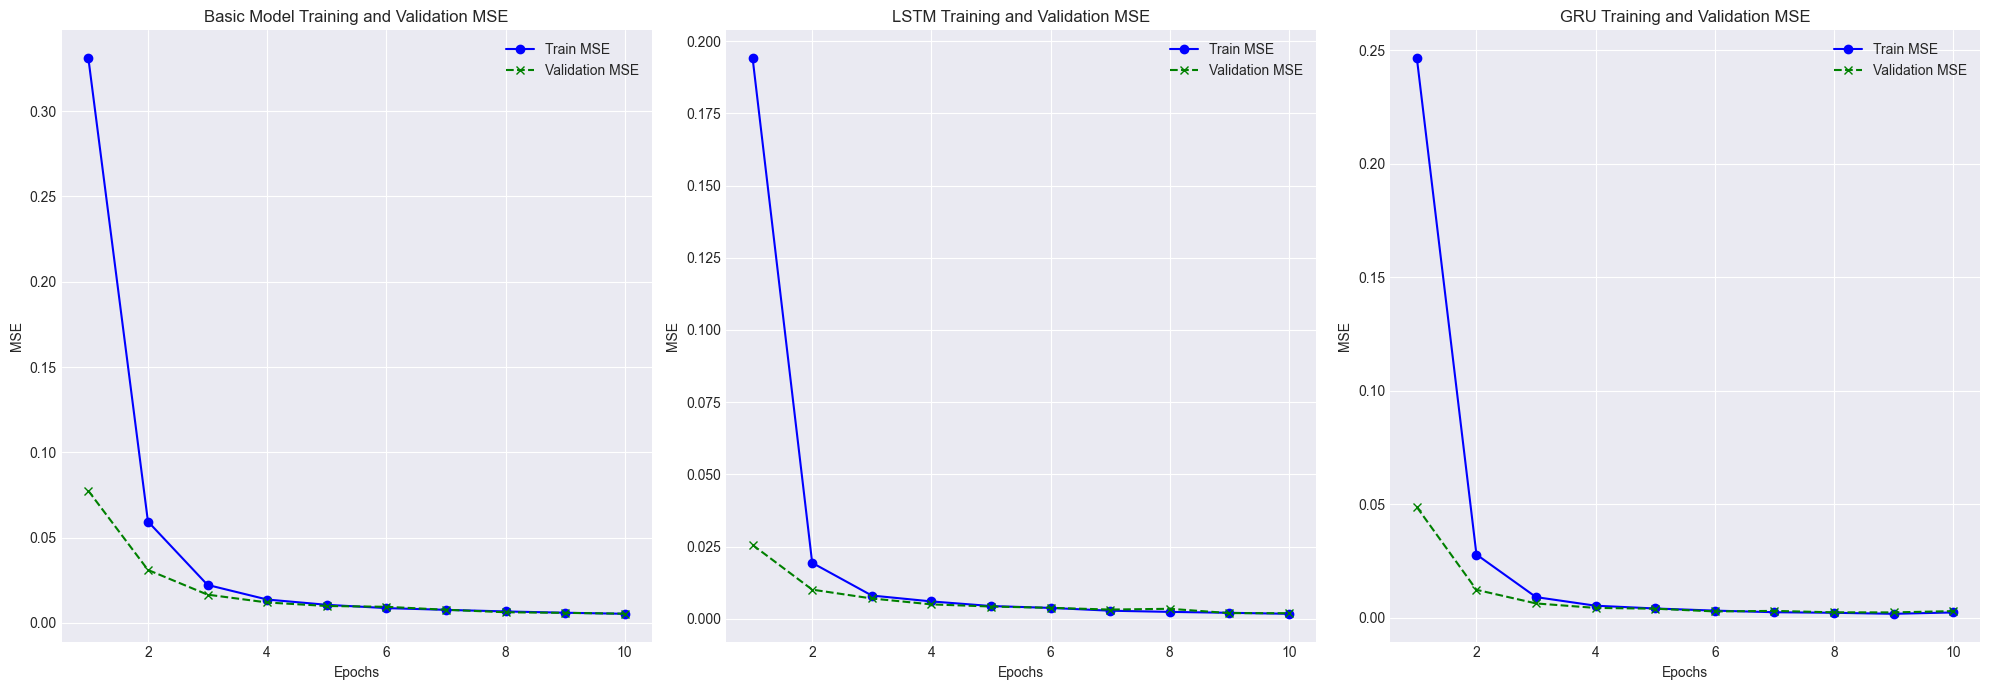

In [30]:
import matplotlib.pyplot as plt

# Create subplots for the graphs
plt.figure(figsize=(20, 7))

# Plot the graph for the first model (Model)
plt.subplot(131)
plt.plot(range(1, 11), history.history['mse'], label='Train MSE', color='blue', linestyle='-', marker='o')
plt.plot(range(1, 11), history.history['val_mse'], label='Validation MSE', color='green', linestyle='--', marker='x')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Basic Model Training and Validation MSE')
plt.legend()
plt.grid(True)

# Plot the graph for the second model (LSTM)
plt.subplot(132)
plt.plot(range(1, 11), lstm_history.history['mse'], label='Train MSE', color='blue', linestyle='-', marker='o')
plt.plot(range(1, 11), lstm_history.history['val_mse'], label='Validation MSE', color='green', linestyle='--', marker='x')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('LSTM Training and Validation MSE')
plt.legend()
plt.grid(True)

# Plot the graph for the third model (GRU)
plt.subplot(133)
plt.plot(range(1, 11), gru_history.history['mse'], label='Train MSE', color='blue', linestyle='-', marker='o')
plt.plot(range(1, 11), gru_history.history['val_mse'], label='Validation MSE', color='green', linestyle='--', marker='x')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('GRU Training and Validation MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save the plot as an image (optional)
plt.savefig('mse_vs_epochs.png')

# Show the plot
plt.show()


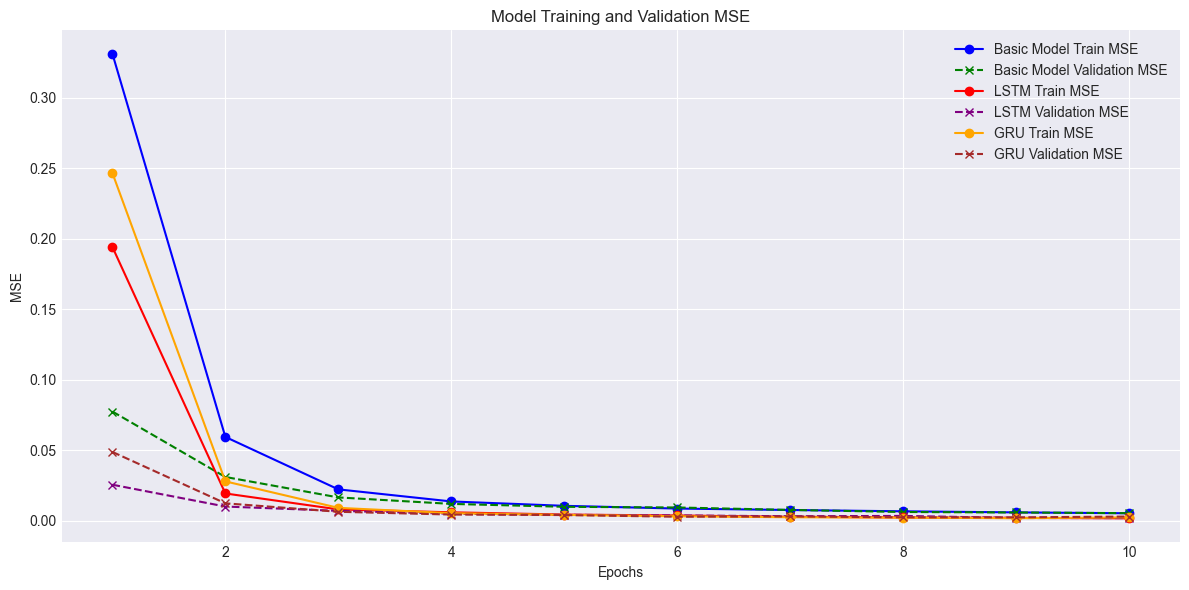

In [31]:
import matplotlib.pyplot as plt

# Create a single plot for all three models
plt.figure(figsize=(12, 6))

# Plot the graph for the first model (Model)
plt.plot(range(1, 11), history.history['mse'], label='Basic Model Train MSE', color='blue', linestyle='-', marker='o')
plt.plot(range(1, 11), history.history['val_mse'], label='Basic Model Validation MSE', color='green', linestyle='--', marker='x')

# Plot the graph for the second model (LSTM)
plt.plot(range(1, 11), lstm_history.history['mse'], label='LSTM Train MSE', color='red', linestyle='-', marker='o')
plt.plot(range(1, 11), lstm_history.history['val_mse'], label='LSTM Validation MSE', color='purple', linestyle='--', marker='x')

# Plot the graph for the third model (GRU)
plt.plot(range(1, 11), gru_history.history['mse'], label='GRU Train MSE', color='orange', linestyle='-', marker='o')
plt.plot(range(1, 11), gru_history.history['val_mse'], label='GRU Validation MSE', color='brown', linestyle='--', marker='x')

plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Model Training and Validation MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save the plot as an image (optional)
plt.savefig('mse_vs_epochs_combined.png')

# Show the plot
plt.show()


Analyzing the MSE values for the three models (Basic Model, LSTM, and GRU) can provide insights into their performance:

1. **Basic Model**:
   - The training MSE starts relatively high at 0.3311 and decreases with each epoch, indicating an improvement in fitting the training data.
   - The validation MSE follows a similar trend, starting at 0.0774 and also decreasing with each epoch.
   - The higher initial MSE suggests that the basic model might require more training to converge.

2. **LSTM Model**:
   - The LSTM model starts with a lower training MSE of 0.1941, and it consistently decreases with each epoch.
   - The validation MSE also starts lower at 0.0256 and decreases, showing good generalization to unseen data.
   - The LSTM model seems to perform better than the basic model with lower initial MSE and quicker convergence.

3. **GRU Model**:
   - The GRU model exhibits a training MSE of 0.2465 in the beginning and shows significant improvement in later epochs.
   - The validation MSE is also relatively lower at 0.0488 initially and decreases with training.
   - The GRU model's performance is promising and is similar to the LSTM model, with potential for better generalization.

In summary, both the LSTM and GRU models perform better than the basic model in terms of training and validation MSE. The LSTM model appears to have a slightly lower initial training MSE, indicating better early convergence, but both LSTM and GRU models show good potential for fitting the data and generalizing to validation data. Further analysis, such as comparing other metrics and exploring more epochs, can help determine the model that performs the best for your specific task.

## Multiple Train Test Splits

#### Basic Model run for multiple train test splits

In [53]:

# Define the number of splits (iterations)
mul_num_splits = 5

# Create lists to store the results (loss and mse for each split)
mul_split_losses = []
mul_split_mses = []

for mul_split in range(mul_num_splits):
    print(f"Split {mul_split + 1}/{mul_num_splits}")
    
    # Split the data into training and testing sets with a different random state each time
    mul_X_train, mul_X_test, mul_y_train, mul_y_test = train_test_split(df['features'], df['labels'], test_size=0.2, random_state=mul_split)

    # Convert mul_X_train and mul_y_train to NumPy arrays
    mul_X_train = np.array(mul_X_train.tolist())
    mul_y_train = np.array(mul_y_train.tolist())

    # Convert mul_X_test and mul_y_test to NumPy arrays
    mul_X_test = np.array(mul_X_test.tolist())
    mul_y_test = np.array(mul_y_test.tolist())

    # Define a neural network model
    mul_model = models.Sequential([
        layers.Input(shape=(1000, 15)),  # Input shape matches the shape of your features
        layers.Flatten(),  # Flatten the input matrix
        layers.Dense(64, activation='relu'),  # Add a dense layer with ReLU activation
        layers.Dense(4)  # Output layer with 4 units (to match the label dimension)
    ])

    # Compile the mul_model with an appropriate loss function (e.g., mean squared error for regression)
    mul_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Train the model
    mul_model.fit(mul_X_train, mul_y_train, epochs=10, batch_size=32, validation_data=(mul_X_test, mul_y_test))

    # Evaluate the model on the test set
    mul_loss, mul_mse = mul_model.evaluate(mul_X_test, mul_y_test)
    print(f'Test Loss: {mul_loss:.4f}')
    print(f'Mean Squared Error: {mul_mse:.4f}')
    
    # Store the results for this split
    mul_split_losses.append(mul_loss)
    mul_split_mses.append(mul_mse)

# Print the results for all splits
for mul_split in range(mul_num_splits):
    print(f'Split {mul_split + 1} - Test Loss: {mul_split_losses[mul_split]:.4f}, Mean Squared Error: {mul_split_mses[mul_split]:.4f}')

# Calculate and print the average and standard deviation of the evaluation metrics
mul_average_loss = np.mean(mul_split_losses)
mul_std_loss = np.std(mul_split_losses)
mul_average_mse = np.mean(mul_split_mses)
mul_std_mse = np.std(mul_split_mses)
print(f'Average Test Loss: {mul_average_loss:.4f}')
print(f'Standard Deviation of Test Loss: {mul_std_loss:.4f}')
print(f'Average Mean Squared Error: {mul_average_mse:.4f}')
print(f'Standard Deviation of Mean Squared Error: {mul_std_mse:.4f}')

Split 1/5
Epoch 1/10
25/25 [==============================] - 1s 20ms/step - loss: 0.2983 - mse: 0.2983 - val_loss: 0.0784 - val_mse: 0.0784
Epoch 2/10
25/25 [==============================] - 0s 16ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 3/10
25/25 [==============================] - 0s 15ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 4/10
25/25 [==============================] - 0s 15ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 5/10
25/25 [==============================] - 0s 16ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 7/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 8/10
25/25 [==============================] - 0s 17ms/step - loss: 

#### Running the code for different splits of data with LSTM

In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Define the number of splits (iterations)
mul_lstm_num_splits = 5

# Create lists to store the results (loss and mse for each split)
mul_lstm_split_losses = []
mul_lstm_split_mses = []

for mul_lstm_split in range(mul_lstm_num_splits):
    print(f"Split {mul_lstm_split + 1}/{mul_lstm_num_splits}")
    
    # Split the data into training and testing sets with a different random state each time
    mul_lstm_X_train, mul_lstm_X_test, mul_lstm_y_train, mul_lstm_y_test = train_test_split(df['features'], df['labels'], test_size=0.2, random_state=mul_lstm_split)

    # Convert mul_lstm_X_train and mul_lstm_y_train to NumPy arrays
    mul_lstm_X_train = np.array(mul_lstm_X_train.tolist())
    mul_lstm_y_train = np.array(mul_lstm_y_train.tolist())

    # Convert mul_lstm_X_test and mul_lstm_y_test to NumPy arrays
    mul_lstm_X_test = np.array(mul_lstm_X_test.tolist())
    mul_lstm_y_test = np.array(mul_lstm_y_test.tolist())

    # Define a neural network model
    mul_lstm_model = models.Sequential([
        layers.Input(shape=(1000, 15)),  # Input shape matches the shape of your features
        layers.Flatten(),  # Flatten the input matrix
        layers.Dense(64, activation='relu'),  # Add a dense layer with ReLU activation
        layers.Dense(4)  # Output layer with 4 units (to match the label dimension)
    ])

    # Compile the mul_lstm_model with an appropriate loss function (e.g., mean squared error for regression)
    mul_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Train the model
    mul_lstm_model.fit(mul_lstm_X_train, mul_lstm_y_train, epochs=10, batch_size=32, validation_data=(mul_lstm_X_test, mul_lstm_y_test))

    # Evaluate the model on the test set
    mul_lstm_loss, mul_lstm_mse = mul_lstm_model.evaluate(mul_lstm_X_test, mul_lstm_y_test)
    print(f'Test Loss: {mul_lstm_loss:.4f}')
    print(f'Mean Squared Error: {mul_lstm_mse:.4f}')
    
    # Store the results for this split
    mul_lstm_split_losses.append(mul_lstm_loss)
    mul_lstm_split_mses.append(mul_lstm_mse)

# Print the results for all splits
for mul_lstm_split in range(mul_lstm_num_splits):
    print(f'Split {mul_lstm_split + 1} - Test Loss: {mul_lstm_split_losses[mul_lstm_split]:.4f}, Mean Squared Error: {mul_lstm_split_mses[mul_lstm_split]:.4f}')

# Calculate and print the average and standard deviation of the evaluation metrics
mul_lstm_average_loss = np.mean(mul_lstm_split_losses)
mul_lstm_std_loss = np.std(mul_lstm_split_losses)
mul_lstm_average_mse = np.mean(mul_lstm_split_mses)
mul_lstm_std_mse = np.std(mul_lstm_split_mses)
print(f'Average Test Loss: {mul_lstm_average_loss:.4f}')
print(f'Standard Deviation of Test Loss: {mul_lstm_std_loss:.4f}')
print(f'Average Mean Squared Error: {mul_lstm_average_mse:.4f}')
print(f'Standard Deviation of Mean Squared Error: {mul_lstm_std_mse:.4f}')

Split 1/5
Epoch 1/10
25/25 [==============================] - 1s 20ms/step - loss: 0.2464 - mse: 0.2464 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 2/10
25/25 [==============================] - 0s 15ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 3/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 4/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5/10
25/25 [==============================] - 0s 15ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 6/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 8/10
25/25 [==============================] - 0s 14ms/step - loss: 

#### Running the code for different splits of data with GRU

In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Define the number of splits (iterations)
mul_gru_num_splits = 5

# Create lists to store the results (loss and mse for each split)
mul_gru_split_losses = []
mul_gru_split_mses = []

for mul_gru_split in range(mul_gru_num_splits):
    print(f"Split {mul_gru_split + 1}/{mul_gru_num_splits}")
    
    # Split the data into training and testing sets with a different random state each time
    mul_gru_X_train, mul_gru_X_test, mul_gru_y_train, mul_gru_y_test = train_test_split(df['features'], df['labels'], test_size=0.2, random_state=mul_gru_split)

    # Convert mul_gru_X_train and mul_gru_y_train to NumPy arrays
    mul_gru_X_train = np.array(mul_gru_X_train.tolist())
    mul_gru_y_train = np.array(mul_gru_y_train.tolist())

    # Convert mul_gru_X_test and mul_gru_y_test to NumPy arrays
    mul_gru_X_test = np.array(mul_gru_X_test.tolist())
    mul_gru_y_test = np.array(mul_gru_y_test.tolist())

    # Define a neural network model
    mul_gru_model = models.Sequential([
        layers.Input(shape=(1000, 15)),  # Input shape matches the shape of your features
        layers.Flatten(),  # Flatten the input matrix
        layers.Dense(64, activation='relu'),  # Add a dense layer with ReLU activation
        layers.Dense(4)  # Output layer with 4 units (to match the label dimension)
    ])

    # Compile the mul_gru_model with an appropriate loss function (e.g., mean squared error for regression)
    mul_gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Train the model
    mul_gru_model.fit(mul_gru_X_train, mul_gru_y_train, epochs=10, batch_size=32, validation_data=(mul_gru_X_test, mul_gru_y_test))

    # Evaluate the model on the test set
    mul_gru_loss, mul_gru_mse = mul_gru_model.evaluate(mul_gru_X_test, mul_gru_y_test)
    print(f'Test Loss: {mul_gru_loss:.4f}')
    print(f'Mean Squared Error: {mul_gru_mse:.4f}')
    
    # Store the results for this split
    mul_gru_split_losses.append(mul_gru_loss)
    mul_gru_split_mses.append(mul_gru_mse)

# Print the results for all splits
for mul_gru_split in range(mul_gru_num_splits):
    print(f'Split {mul_gru_split + 1} - Test Loss: {mul_gru_split_losses[mul_gru_split]:.4f}, Mean Squared Error: {mul_gru_split_mses[mul_gru_split]:.4f}')

# Calculate and print the average and standard deviation of the evaluation metrics
mul_gru_average_loss = np.mean(mul_gru_split_losses)
mul_gru_std_loss = np.std(mul_gru_split_losses)
mul_gru_average_mse = np.mean(mul_gru_split_mses)
mul_gru_std_mse = np.std(mul_gru_split_mses)
print(f'Average Test Loss: {mul_gru_average_loss:.4f}')
print(f'Standard Deviation of Test Loss: {mul_gru_std_loss:.4f}')
print(f'Average Mean Squared Error: {mul_gru_average_mse:.4f}')
print(f'Standard Deviation of Mean Squared Error: {mul_gru_std_mse:.4f}')

Split 1/5
Epoch 1/10
25/25 [==============================] - 1s 21ms/step - loss: 0.3008 - mse: 0.3008 - val_loss: 0.0899 - val_mse: 0.0899
Epoch 2/10
25/25 [==============================] - 0s 15ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 3/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 4/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 5/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 7/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 8/10
25/25 [==============================] - 0s 14ms/step - loss: 

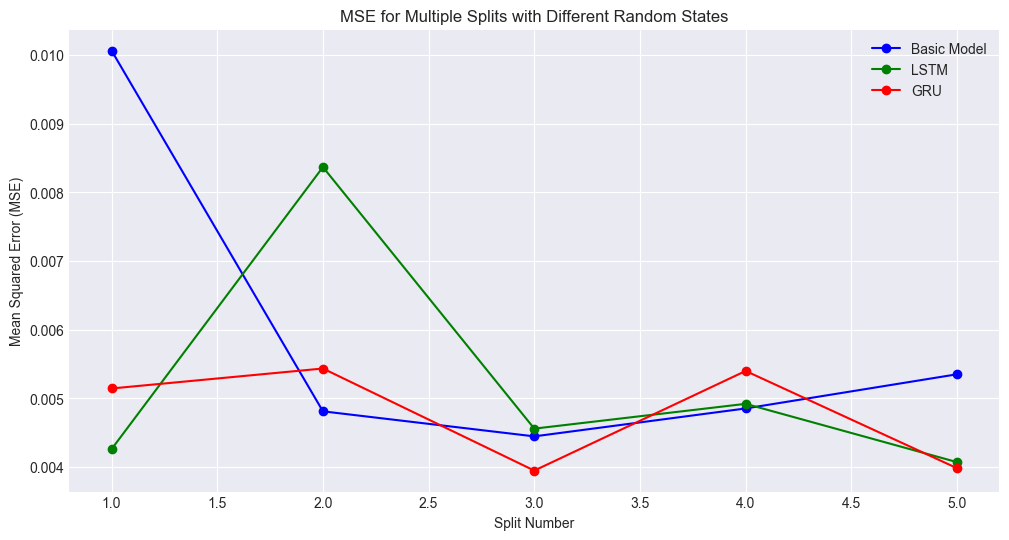

In [62]:
import matplotlib.pyplot as plt

# Create a list of split numbers for x-axis
split_numbers = range(1, mul_num_splits + 1)

# Create subplots for the graphs
plt.figure(figsize=(12, 6))

# Plot the MSE values for the Basic Model
plt.plot(split_numbers, mul_split_mses, marker='o', linestyle='-', color='blue', label='Basic Model')

# Plot the MSE values for the LSTM
plt.plot(split_numbers, mul_lstm_split_mses, marker='o', linestyle='-', color='green', label='LSTM')

# Plot the MSE values for the GRU
plt.plot(split_numbers, mul_gru_split_mses, marker='o', linestyle='-', color='red', label='GRU')

plt.xlabel('Split Number')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Multiple Splits with Different Random States')
plt.legend()
plt.grid(True)

# Save the plot as an image (optional)
plt.savefig('mse_for_multiple_splits_combined_tests2.png')

# Show the plot
plt.show()
